## Few imports

In [1]:
import numpy as np
import pandas as pd
import nibabel as nib
import matplotlib.pyplot as plt
from tqdm import tqdm
from nilearn import plotting
from nibabel import processing
from joblib import Parallel, delayed
import sklearn
import seaborn as sns


# Set-up root and read demography

In [2]:
rootDir = '../../../Desktop/data'
df = pd.read_excel(f'{rootDir}/IXI.xls')
df.dropna(inplace=True)
df.drop_duplicates(subset='IXI_ID',keep='last', inplace=True)
print(f'dataset is of shape: {df.shape}')
df.drop(columns=['HEIGHT','WEIGHT','ETHNIC_ID','MARITAL_ID','OCCUPATION_ID','QUALIFICATION_ID','DOB','DATE_AVAILABLE','STUDY_DATE'],
        axis=1, inplace=True)
df.head()

dataset is of shape: (565, 12)


,IXI_ID,"SEX_ID (1=m, 2=f)",AGE
1,2,2,35.800137
2,12,1,38.781656
3,13,1,46.710472
4,14,2,34.236824
5,15,1,24.284736


# Load MRI data and reslice to reduce memory 

In [3]:
images = []
id = []
for ids in df['IXI_ID']:
    try:
        image = nib.load(f'{rootDir}/mwp1p2/mwp1IXI{str(ids).zfill(3)}_T1.nii')
        images.append(image)
        id.append(ids)
    except FileNotFoundError:
        print(f'File not found for IXI_ID: {ids}')
reslice = Parallel(n_jobs=10)(
            delayed(processing.resample_to_output)(image, voxel_sizes=(2,2,2))
            for image in images
)


File not found for IXI_ID: 116
File not found for IXI_ID: 182
File not found for IXI_ID: 309
File not found for IXI_ID: 500
File not found for IXI_ID: 580
File not found for IXI_ID: 628


Apply FWHM = 4mm

In [4]:
# if there are multiple cores available
# smoothed_images = Parallel(n_jobs=-1)(
#     delayed(processing.smooth_image)(reslice_image, fwhm=4.0)
#     for reslice_image in reslice
# )
smooth = [processing.smooth_image(reslice_image, fwhm=4) for reslice_image in tqdm(reslice)]

100%|██████████| 559/559 [00:11<00:00, 46.81it/s]


Plot one image to see what it looks like

Text(0.5, 1.0, 'gray matter segmentation of T1w-MRI image')

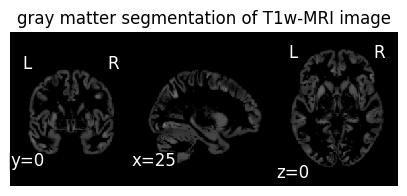

In [5]:
fig, ax = plt.subplots(figsize=(5,2))
plotting.plot_anat(images[0], axes=ax, draw_cross=False)
ax.set_title('gray matter segmentation of T1w-MRI image')

Apply PCA on the feature set with 10-20 components. Otherwise, the feature set will be of size 9135399 (or) ~9Million. This is also the reason, why we reslice the image.

In [6]:
# flatten the images
features = [np.array(smooth[i].get_fdata()).flatten() for i in tqdm(range(0,len(smooth)))]

# scale the features for PCA
stdScalar = sklearn.preprocessing.StandardScaler()
features = stdScalar.fit_transform(features)

# apply PCA
pca = sklearn.decomposition.PCA(n_components = 20)
components = pca.fit_transform(features)

X = components
y = df[df['IXI_ID'].isin(id)]['AGE']

100%|██████████| 559/559 [00:02<00:00, 241.70it/s]


# nested approach to find a minimal leakage predictions

In [7]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import Ridge
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_absolute_error as mae
import joblib

model = Pipeline([('ridge', Ridge(max_iter=1000))])
              
p_grid= {'ridge__alpha': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
in_cv = KFold(n_splits=10, shuffle=True, random_state=42)
out_cv = KFold(n_splits=10, shuffle=True, random_state=42)

mae_per_fold = []
# define gridSearch
clf = GridSearchCV(estimator=model,
                   param_grid=p_grid,
                   cv=in_cv,
                   verbose=True)

pred = np.zeros(len(y))
count = 0
for train,test in out_cv.split(X, y):
    clf.fit(X[train], y.iloc[train])
    pred[test] = clf.predict(X[test])

    MAE =mae(pred[test], y.iloc[test])
    print(f'mean absolute error of fold {count} is: {round(MAE,2)}')
    print(clf.best_params_)
    print('************************')
    mae_per_fold.append(MAE)
    count += count
mae_final = mae(pred, y)
print(f'mean absolute error Final {count} is: {round(mae_final,2)}')



Fitting 10 folds for each of 7 candidates, totalling 70 fits
mean absolute error of fold 0 is: 8.12
{'ridge__alpha': 1000}
************************
Fitting 10 folds for each of 7 candidates, totalling 70 fits
mean absolute error of fold 0 is: 9.17
{'ridge__alpha': 1000}
************************
Fitting 10 folds for each of 7 candidates, totalling 70 fits
mean absolute error of fold 0 is: 7.06
{'ridge__alpha': 1000}
************************
Fitting 10 folds for each of 7 candidates, totalling 70 fits
mean absolute error of fold 0 is: 7.21
{'ridge__alpha': 1000}
************************
Fitting 10 folds for each of 7 candidates, totalling 70 fits
mean absolute error of fold 0 is: 8.83
{'ridge__alpha': 1000}
************************
Fitting 10 folds for each of 7 candidates, totalling 70 fits
mean absolute error of fold 0 is: 6.17
{'ridge__alpha': 1000}
************************
Fitting 10 folds for each of 7 candidates, totalling 70 fits
mean absolute error of fold 0 is: 6.63
{'ridge__alp

Overall we found alpha stable at 1000. Now train a final non-nested model using full dataset and dump it.

In [8]:
clf = Ridge(max_iter=1000, alpha=1000)
clf.fit(X, y)
joblib.dump(clf, 'final_model.joblib')

use_model = joblib.load('final_model.joblib')
predicted_age = use_model.predict(X)
print(f'biased MAE = {mae(predicted_age, y)}')

biased MAE = 7.042499201505674


### Plot the MAE per cross-validation, the hyperparameter alpha per cross-validation, and the actual predicted versus target age performance

Text(0.5, 1.0, 'Stability per cross-validation')

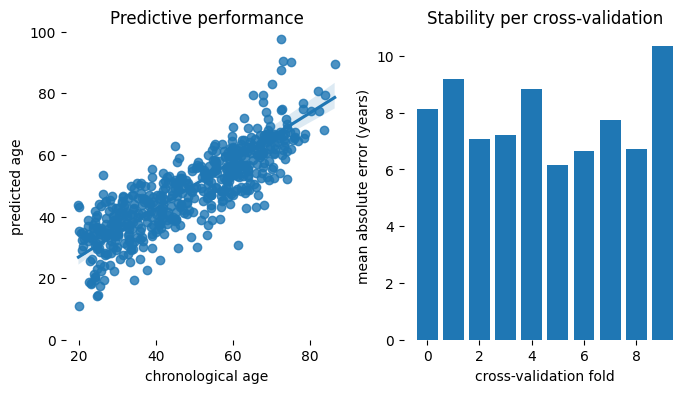

In [9]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))
sns.regplot(x = y, y = pred, ax=ax1)
ax1.set_ylim([0,100])
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('chronological age')
ax1.set_ylabel('predicted age')
ax1.set_title('Predictive performance')

ax2.bar(np.arange(len(mae_per_fold)), np.array(mae_per_fold))
ax2.spines['top'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax2.set_xlabel('cross-validation fold')
ax2.set_ylabel('mean absolute error (years)')
ax2.set_title('Stability per cross-validation')

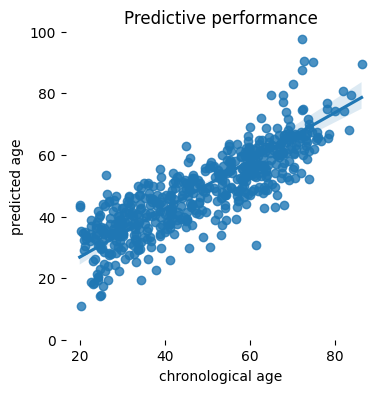

In [12]:
fig, ax1= plt.subplots(figsize=(4,4))
sns.regplot(x = y, y = pred, ax=ax1)
ax1.set_ylim([0,100])
ax1.spines['top'].set_visible(False)
ax1.spines['bottom'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.set_xlabel('chronological age')
ax1.set_ylabel('predicted age')
ax1.set_title('Predictive performance')
plt.savefig('performance.jpeg', dpi= 1200)